In [0]:
import os
from google.colab import drive, files

drive.mount('/content/drive', force_remount=True)
!ls '/content/drive/My Drive/Colab Notebooks/'

In [0]:
!rm -rf eplusparser && git clone https://github.com/energy-plus-senior-design/eplusparser.git

%cd eplusparser
%pwd
!pip install .

Cloning into 'eplusparser'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 63 (delta 6), reused 20 (delta 6), pack-reused 43
Unpacking objects: 100% (63/63), done.
/content/eplusparser
Processing /content/eplusparser
  Created wheel for eplusparser: filename=eplusparser-0.1.3-cp36-none-any.whl size=2859 sha256=bd79894e42cdbffea12516fc87ddb0691c43a371053750c04ae6e66e3df0bd43
  Stored in directory: /tmp/pip-ephem-wheel-cache-v31rxxsj/wheels/73/df/0d/2ddf4deebbb98a075d23e60603808eec3f8acdbb19941dd6e4
Successfully built eplusparser


In [0]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 18 18:50:22 2019

@author: Vivian, Sameer
"""

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3
import math
import keras
import keras.backend as K
from sklearn.preprocessing import normalize
from eplusparser import parse, get_uxy
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import sqlite3

Using TensorFlow backend.


In [0]:
df = parse('/content/drive/My Drive/EnergyPlus Senior Design/SQL Files/eplusout_largeoffice_darksky_2009_2019.sql')
df.head()
dataset = df.values
names = df.columns.values.tolist()

# get u_t, x_t, y_t
u_orig_df, x_orig_df, y_orig_df = get_uxy(df)
print('u_t: ' + str(u_orig_df.head()))
print('x_t: ' + str(x_orig_df.head()))
print('y_t: ' + str(y_orig_df.head()))

u_t: VariableName Schedule Value               ... Zone Thermostat Heating Setpoint Temperature                   
KeyValue       ACTIVITY_SCH AIR_VELO_SCH  ...                           PERIMETER_TOP_ZN_3 PERIMETER_TOP_ZN_4
TimeIndex                                 ...                                                                
1                     120.0          0.2  ...                                         21.0               21.0
2                     120.0          0.2  ...                                         21.0               21.0
3                     120.0          0.2  ...                                         21.0               21.0
4                     120.0          0.2  ...                                         21.0               21.0
5                     120.0          0.2  ...                                         21.0               21.0

[5 rows x 124 columns]
x_t: VariableName Zone Air Humidity Ratio  ... Zone Mean Air Temperature
KeyValue          

In [0]:
u_orig_df.to_pickle('/content/drive/My Drive/EnergyPlus Senior Design/hybrid_u.pickle')
x_orig_df.to_pickle('/content/drive/My Drive/EnergyPlus Senior Design/hybrid_x.pickle')
y_orig_df.to_pickle('/content/drive/My Drive/EnergyPlus Senior Design/hybrid_y.pickle')
u_orig = u_orig_df.values
x_orig = x_orig_df.values
y_orig = y_orig_df.values

In [0]:
# normalize the dataset
scalerU = MinMaxScaler(feature_range=(-1, 1))
scalerX = MinMaxScaler(feature_range=(-1, 1))
scalerY = MinMaxScaler(feature_range=(-1, 1))

u_t = scalerU.fit_transform(u_orig)
x_t = scalerX.fit_transform(x_orig)
y_t = scalerY.fit_transform(y_orig)

# split into train and test sets
remove_size = int(len(u_t) * 1/11)  # remove first year
train_size = int(len(u_t) * 9/11)   # 9 years training
test_size = len(u_t) - train_size - remove_size  # 1 year testing
u_removeset, u_trainset, u_testset = u_t[0:remove_size,:], u_t[remove_size:remove_size+train_size,:], u_t[remove_size+train_size:,:]
x_removeset, x_trainset, x_testset = x_t[0:remove_size,:], x_t[remove_size:remove_size+train_size,:], x_t[remove_size+train_size:,:]
y_removeset, y_trainset, y_testset = y_t[0:remove_size,:], y_t[remove_size:remove_size+train_size,:], y_t[remove_size+train_size:,:]

print(len(u_trainset), len(u_testset))

78918 8770


In [0]:
# model = keras.models.load_model('/content/drive/My Drive/EnergyPlus Senior Design/models/hybrid_2019-11-12_2.h5')

In [0]:
u_trainset.shape[1]

124

In [0]:
def create_model(trainU, trainX, trainY, look_back=1):
    input = keras.layers.Input(shape=(look_back, trainU.shape[1],))
    reshape1 = keras.layers.Reshape((trainU.shape[1] * look_back,))(input)
    indexed = reshape1[:trainU.shape[1]]
    lstm = LSTM(16, input_shape=(look_back, trainU.shape[1]))(input)
    dense1 = Dense(trainX.shape[1])(lstm)
    concat1 = keras.layers.Concatenate()([reshape1, dense1])
    print(concat1)
    dense2 = Dense(64, activation='relu')(concat1)
    dense3 = Dense(16, activation='relu')(dense2)
    linear1 = Dense(trainY.shape[1], activation='linear')(dense3)
    concat2 = keras.layers.Concatenate()([dense1, linear1])
    print(concat2)

    model = keras.models.Model(inputs=input, outputs=concat2)
    model.compile(loss='mean_squared_error', optimizer='adam')
        
    return model

In [0]:
# create and fit the LSTM network
look_back = 1
model = create_model(u_trainset, x_trainset, y_trainset, look_back=look_back)




Tensor("concatenate_1/concat:0", shape=(?, 172), dtype=float32)
Tensor("concatenate_2/concat:0", shape=(?, 50), dtype=float32)



In [0]:
xy_trainset = np.concatenate([x_trainset, y_trainset], axis=1)
u_trainset_repeat = u_trainset[:, np.newaxis, :]
u_trainset_repeat = np.repeat(u_trainset_repeat, look_back, axis=1)
u_trainset_repeat.shape

(78918, 1, 124)

In [0]:
xy_trainset

array([[-0.51443953, -0.51668229, -0.52689908, ..., -0.00142993,
         0.09317937, -0.11693581],
       [-0.46089501, -0.43368992, -0.44171832, ..., -0.00172659,
         0.05121317, -0.23056271],
       [-0.42606764, -0.38787392, -0.3945646 , ..., -0.00157835,
        -0.00402897, -0.33123509],
       ...,
       [-0.14912309, -0.13129383, -0.1351948 , ..., -0.00230595,
        -0.45188943, -0.71519025],
       [-0.11075253, -0.0972933 , -0.10128436, ..., -0.00197229,
        -0.45191414, -0.72300123],
       [-0.08321186, -0.07539566, -0.07929361, ..., -0.00173543,
        -0.4519156 , -0.72420874]])

In [0]:
model.fit(u_trainset_repeat, xy_trainset, epochs=30, batch_size=10, verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/30





 - 27s - loss: 0.0166
Epoch 2/30
 - 26s - loss: 0.0134
Epoch 3/30
 - 26s - loss: 0.0130
Epoch 4/30
 - 27s - loss: 0.0128
Epoch 5/30
 - 25s - loss: 0.0127
Epoch 6/30
 - 25s - loss: 0.0125
Epoch 7/30
 - 26s - loss: 0.0125
Epoch 8/30
 - 25s - loss: 0.0125
Epoch 9/30
 - 27s - loss: 0.0124
Epoch 10/30
 - 25s - loss: 0.0124
Epoch 11/30
 - 25s - loss: 0.0124
Epoch 12/30
 - 25s - loss: 0.0124
Epoch 13/30
 - 25s - loss: 0.0123
Epoch 14/30
 - 26s - loss: 0.0123
Epoch 15/30
 - 25s - loss: 0.0123
Epoch 16/30
 - 25s - loss: 0.0123
Epoch 17/30
 - 26s - loss: 0.0122
Epoch 18/30
 - 26s - loss: 0.0122
Epoch 19/30
 - 25s - loss: 0.0122
Epoch 20/30
 - 26s - loss: 0.0122
Epoch 21/30
 - 26s - loss: 0.0122
Epoch 22/30
 - 26s - loss: 0.0122
Epoch 23/30
 - 25s - loss: 0.0122
Epoch 24/30
 - 25s - loss: 0.0121
Epoch 25/30
 - 25s - loss: 0.0121
Epoch 26/30
 - 26s - loss: 0.0121
Epoch 27/30
 - 25s - lo

In [0]:
# make predictions
u_testset_repeat = u_testset[:, np.newaxis, :]
u_testset_repeat = np.repeat(u_testset_repeat, look_back, axis=1)
u_testset_repeat.shape

trainPredict = model.predict(u_trainset_repeat)
model.reset_states()
testPredict = model.predict(u_testset_repeat)

# calculate the scaled root mean squared error
xy_testset = np.concatenate([x_testset, y_testset], axis=1)
trainScore = math.sqrt(mean_squared_error(xy_trainset, trainPredict))
print('Train Score of concat(x,y): %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(xy_testset, testPredict))
print('Test Score of concat(x,y): %.2f RMSE' % (testScore))
trainScore = math.sqrt(mean_squared_error(y_trainset, trainPredict[:, -2:]))
print('Train Score of y: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_testset, testPredict[:, -2:]))
print('Test Score of y: %.3f RMSE' % (testScore))

print(y_testset)
print(testPredict[-2:])

Train Score of concat(x,y): 0.11 RMSE
Test Score of concat(x,y): 0.11 RMSE
Train Score of y: 0.045 RMSE
Test Score of y: 0.049 RMSE
[[-0.73073687 -0.62022266]
 [-0.73067619 -0.60810643]
 [-0.6375771  -0.59205671]
 ...
 [-0.72993373 -0.83985398]
 [-0.75244713 -0.81666067]
 [-0.78462238 -0.82497387]]
[[-0.3862515  -0.322807   -0.3880599  -0.46853048 -0.7706213  -0.7702992
  -0.77031136 -0.77061445 -0.76294136 -0.7630252  -0.76247036 -0.7634558
  -0.7332684  -0.72980976 -0.73348826 -0.72999644 -0.3901679   0.01826066
  -0.06891027 -0.8141172  -0.3947592  -0.6078907  -0.68468225 -0.6711722
  -0.49363637 -0.71948165 -0.78128886 -0.76230335 -0.71419215 -0.82923144
  -0.84238887 -0.8770487  -0.3902107   0.01826401 -0.06893387 -0.8141165
  -0.39476812 -0.60788023 -0.68460304 -0.67119324 -0.493654   -0.7194519
  -0.78125    -0.76232916 -0.714169   -0.82920855 -0.84237367 -0.87702316
  -0.8146809  -0.9424206 ]
 [-0.40818095 -0.34532315 -0.40311062 -0.48027772 -0.76333463 -0.76455027
  -0.7629023

In [0]:
# invert predictions
y_train_pred_inv = scalerY.inverse_transform(trainPredict[:, -2:])
y_traininv = scalerY.inverse_transform(y_trainset)
y_test_pred_inv = scalerY.inverse_transform(testPredict[:, -2:])
y_testinv = scalerY.inverse_transform(y_testset)

x_train_pred_inv = scalerX.inverse_transform(trainPredict[:, :-2])
x_traininv = scalerX.inverse_transform(x_trainset)
x_test_pred_inv = scalerX.inverse_transform(testPredict[:, :-2])
x_testinv = scalerX.inverse_transform(x_testset)

trainScore = math.sqrt(mean_squared_error(y_traininv, y_train_pred_inv))
print('Train Score of y: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_testinv, y_test_pred_inv))
print('Test Score of y: %.2f RMSE' % (testScore))
  
print('trainPredict')
print(y_train_pred_inv)
print('actualtrainY')
print(y_traininv)
print('testPredict')
print(y_test_pred_inv)
print('actualtestY')
print(y_testinv)


Train Score of y: 227591441.42 RMSE
Test Score of y: 257193446.53 RMSE
trainPredict
[[3.8188618e+09 3.0069673e+09]
 [3.7004140e+09 2.6510438e+09]
 [3.5008911e+09 2.2002650e+09]
 ...
 [2.0344922e+09 1.3659105e+09]
 [2.0282561e+09 1.3097047e+09]
 [2.0249402e+09 1.3348068e+09]]
actualtrainY
[[3.78519495e+09 5.38893844e+09]
 [3.65030415e+09 4.69553444e+09]
 [3.47274086e+09 4.08118501e+09]
 ...
 [2.03319542e+09 1.73811293e+09]
 [2.03311599e+09 1.69044673e+09]
 [2.03311129e+09 1.68307792e+09]]
testPredict
[[1.1422817e+09 1.8162528e+09]
 [1.1425690e+09 1.5502493e+09]
 [1.4262600e+09 2.1734090e+09]
 ...
 [1.0177517e+09 2.5534349e+08]
 [8.6708499e+08 3.5144813e+08]
 [7.8059386e+08 1.9661627e+08]]
actualtestY
[[1.13690385e+09 2.31764912e+09]
 [1.13709889e+09 2.39158797e+09]
 [1.43634470e+09 2.48953080e+09]
 ...
 [1.13948534e+09 9.77357160e+08]
 [1.06712115e+09 1.11889346e+09]
 [9.63701153e+08 1.06816246e+09]]


In [0]:
# serialize models
model.save('/content/drive/My Drive/EnergyPlus Senior Design/models/explicit_2019-12-03.h5')
import pickle
with open('/content/drive/My Drive/EnergyPlus Senior Design/models/explicit_2019-12-03_scalerU.pickle', 'wb') as f:
    pickle.dump(scalerU, f)
with open('/content/drive/My Drive/EnergyPlus Senior Design/models/explicit_2019-12-03_scalerX.pickle', 'wb') as f:
    pickle.dump(scalerX, f)
with open('/content/drive/My Drive/EnergyPlus Senior Design/models/explicit_2019-12-03_scalerY.pickle', 'wb') as f:
    pickle.dump(scalerY, f)

In [0]:
pd.DataFrame(data=y_test_pred_inv, columns=y_orig_df.columns).to_pickle('/content/drive/My Drive/EnergyPlus Senior Design/models/explicit_2019-12-03_y_pred.pickle')
pd.DataFrame(data=y_testinv, columns=y_orig_df.columns).to_pickle('/content/drive/My Drive/EnergyPlus Senior Design/models/explicit_2019-12-03_y_real.pickle')
pd.DataFrame(data=x_test_pred_inv, columns=x_orig_df.columns).to_pickle('/content/drive/My Drive/EnergyPlus Senior Design/models/explicit_2019-12-03_x_pred.pickle')
pd.DataFrame(data=x_testinv, columns=x_orig_df.columns).to_pickle('/content/drive/My Drive/EnergyPlus Senior Design/models/explicit_2019-12-03_x_real.pickle')

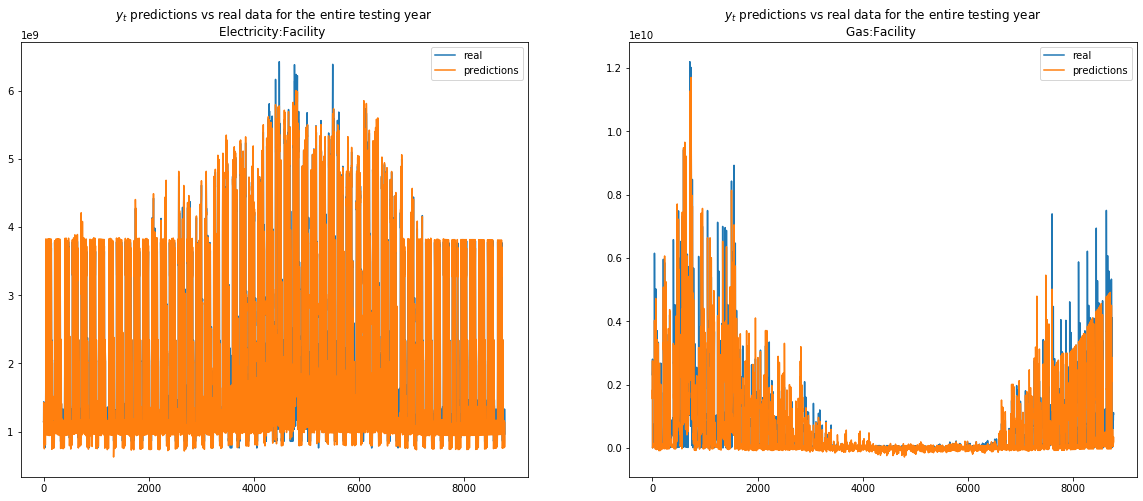

In [0]:
# let's plot
from math import ceil
ncols = 2
ycols = len(y_orig_df.columns)

fig, axes = plt.subplots(nrows=ceil(ycols / ncols), ncols=ncols, figsize=(20, 8))

for i, col in enumerate(y_orig_df.columns):
    axes[i].plot(y_testinv[:, i], label='real')
    axes[i].plot(y_test_pred_inv[:, i], label='predictions')
    axes[i].legend(fontsize=10)
    axes[i].set_title('$y_t$ predictions vs real data for the entire testing year\n' + ' '.join(col))

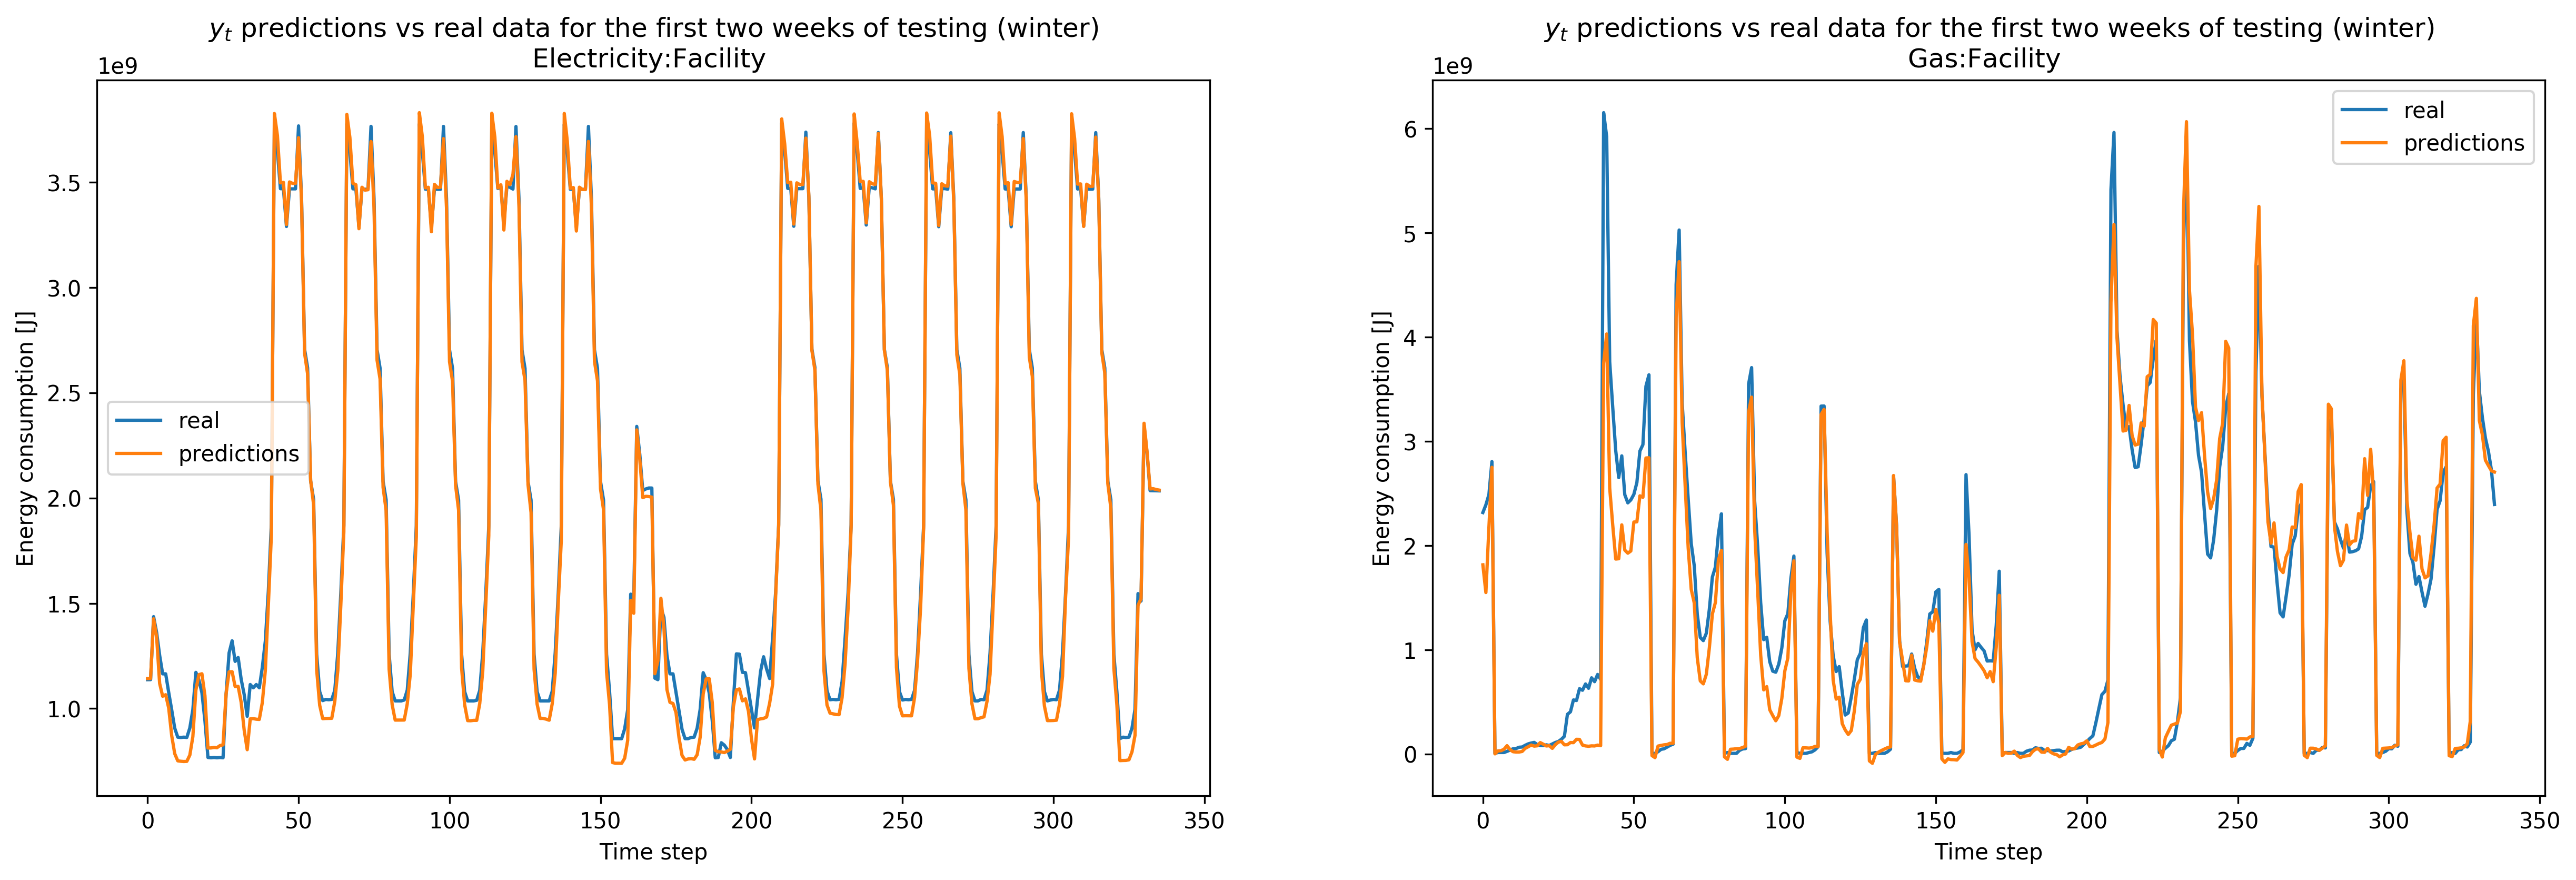

In [0]:
ncols = 2
ycols = len(y_orig_df.columns)
timelimit = 24 * 7 * 2

fig, axes = plt.subplots(nrows=ceil(ycols / ncols), ncols=ncols, figsize=(20, 6), dpi=300)

for i, col in enumerate(y_orig_df.columns):
    axes[i].plot(y_testinv[:timelimit, i], label='real')
    axes[i].plot(y_test_pred_inv[:timelimit, i], label='predictions')
    axes[i].legend(fontsize=10)
    axes[i].set_title('$y_t$ predictions vs real data for the first two weeks of testing (winter)\n' + ' '.join(col))
    axes[i].set_ylabel('Energy consumption [J]')
    axes[i].set_xlabel('Time step')

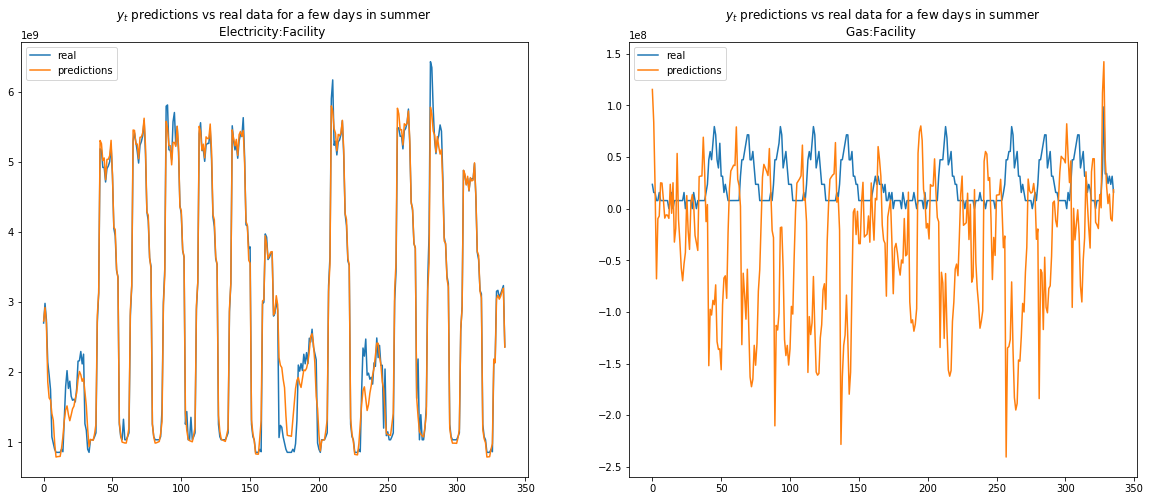

In [0]:
ncols = 2
ycols = len(y_orig_df.columns)
offset = 24 * 7 * 25
timelimit = 24 * 7 * 2

fig, axes = plt.subplots(nrows=ceil(ycols / ncols), ncols=ncols, figsize=(20, 8))

for i, col in enumerate(y_orig_df.columns):
    axes[i].plot(y_testinv[offset:offset+timelimit, i], label='real')
    axes[i].plot(y_test_pred_inv[offset:offset+timelimit, i], label='predictions')
    axes[i].legend(fontsize=10)
    axes[i].set_title('$y_t$ predictions vs real data for a few days in summer\n' + ' '.join(col))

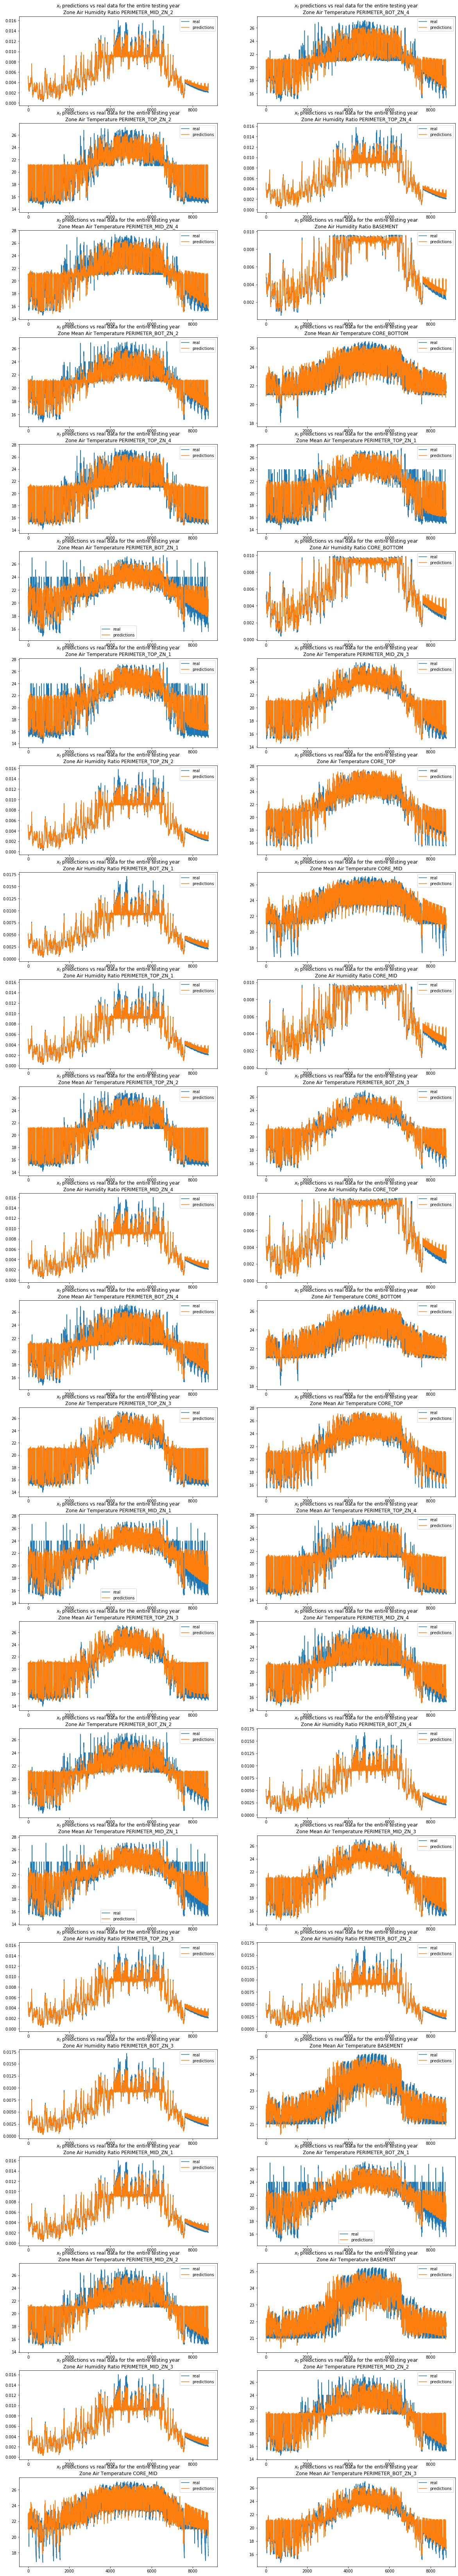

In [0]:
# let's plot
from math import ceil
ncols = 2
ycols = len(x_orig_df.columns)

fig, axes = plt.subplots(nrows=ceil(ycols / ncols), ncols=ncols, figsize=(20, 120))

for i, col in enumerate(x_orig_df.columns):
    a = axes[i//ncols, i%ncols]
    a.plot(x_testinv[:, i], label='real')
    a.plot(x_test_pred_inv[:, i], label='predictions')
    a.legend(fontsize=10)
    a.set_title('$x_t$ predictions vs real data for the entire testing year\n' + ' '.join(col))

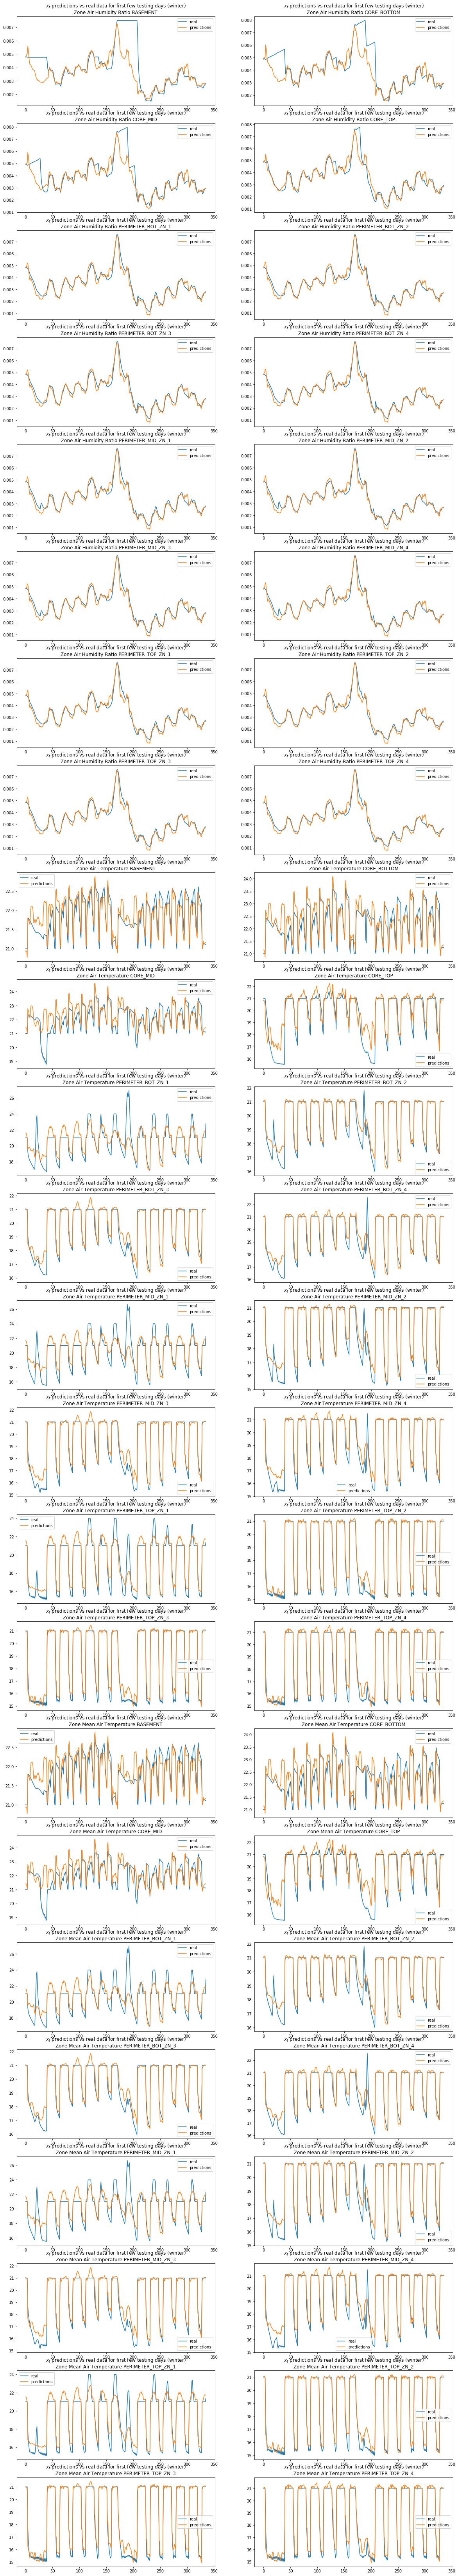

In [0]:
ncols = 2
ycols = len(x_orig_df.columns)
offset = 24 * 7 * 25
timelimit = 24 * 7 * 2

fig, axes = plt.subplots(nrows=ceil(ycols / ncols), ncols=ncols, figsize=(20, 120))

for i, col in enumerate(x_orig_df.columns):
    a = axes[i//ncols, i%ncols]
    a.plot(x_testinv[:timelimit, i], label='real')
    a.plot(x_test_pred_inv[:timelimit, i], label='predictions')
    a.legend(fontsize=10)
    a.set_title('$x_t$ predictions vs real data for first few testing days (winter)\n' + ' '.join(col))

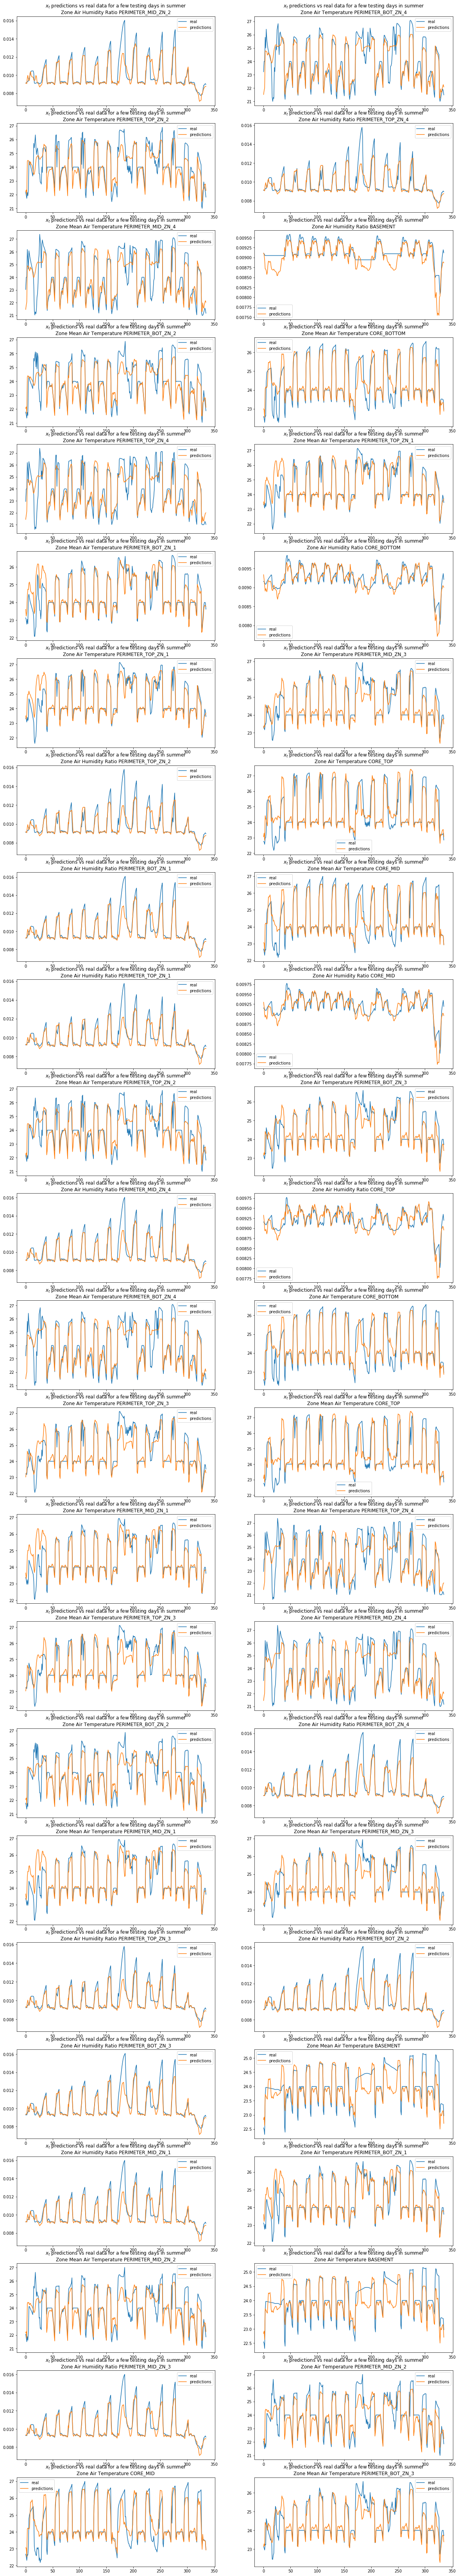

In [0]:
ncols = 2
ycols = len(x_orig_df.columns)
offset = 24 * 7 * 25
timelimit = 24 * 7 * 2

fig, axes = plt.subplots(nrows=ceil(ycols / ncols), ncols=ncols, figsize=(20, 120))

for i, col in enumerate(x_orig_df.columns):
    a = axes[i//ncols, i%ncols]
    a.plot(x_testinv[offset:offset+timelimit, i], label='real')
    a.plot(x_test_pred_inv[offset:offset+timelimit, i], label='predictions')
    a.legend(fontsize=10)
    a.set_title('$x_t$ predictions vs real data for a few testing days in summer\n' + ' '.join(col))